# Classificação de Imagens com CNN: Cats vs Dogs 🐱🐶
Este notebook utiliza uma rede neural convolucional (CNN) para classificar imagens de gatos e cachorros.

In [ ]:
import kagglehub
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV
import torch.optim as optim

# Baixar dataset
path = kagglehub.dataset_download("jakupymeraj/cats-and-dogs-image-dataset")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\Welton Dionisio\.cache\kagglehub\datasets\jakupymeraj\cats-and-dogs-image-dataset\versions\1


In [26]:
# Verificar estrutura de pastas
from pathlib import Path
dataset_path = Path(path)
list(dataset_path.glob("**/*"))[:10]  # Mostrar os primeiros arquivos

[WindowsPath('C:/Users/Welton Dionisio/.cache/kagglehub/datasets/jakupymeraj/cats-and-dogs-image-dataset/versions/1/dataset'),
 WindowsPath('C:/Users/Welton Dionisio/.cache/kagglehub/datasets/jakupymeraj/cats-and-dogs-image-dataset/versions/1/dataset/test_set'),
 WindowsPath('C:/Users/Welton Dionisio/.cache/kagglehub/datasets/jakupymeraj/cats-and-dogs-image-dataset/versions/1/dataset/training_set'),
 WindowsPath('C:/Users/Welton Dionisio/.cache/kagglehub/datasets/jakupymeraj/cats-and-dogs-image-dataset/versions/1/dataset/test_set/cats'),
 WindowsPath('C:/Users/Welton Dionisio/.cache/kagglehub/datasets/jakupymeraj/cats-and-dogs-image-dataset/versions/1/dataset/test_set/dogs'),
 WindowsPath('C:/Users/Welton Dionisio/.cache/kagglehub/datasets/jakupymeraj/cats-and-dogs-image-dataset/versions/1/dataset/test_set/cats/cat.4001.jpg'),
 WindowsPath('C:/Users/Welton Dionisio/.cache/kagglehub/datasets/jakupymeraj/cats-and-dogs-image-dataset/versions/1/dataset/test_set/cats/cat.4002.jpg'),
 Window

In [29]:
# Verificar subpastas disponíveis no dataset_path
print("Conteúdo do dataset_path:", list(dataset_path.iterdir()))

Conteúdo do dataset_path: [WindowsPath('C:/Users/Welton Dionisio/.cache/kagglehub/datasets/jakupymeraj/cats-and-dogs-image-dataset/versions/1/dataset')]


Resumo:

Use train_dataset e train_loader para treino/validação.
Use test_dataset e test_loader apenas para avaliação final.
Agora, as classes serão ['cats', 'dogs'] (ou equivalente), e não ['training_set', 'test_set'].

In [30]:
# Definir transformações para treino e validação, como flips, rotações, crops, etc., para gerar mais variedade nas imagens de treino.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Caminhos para treino e teste
data_dir = dataset_path
train_dir = data_dir / "training_set"
test_dir = data_dir / "test_set"

# Carregar datasets separados
data_dir = dataset_path / "dataset"
train_dir = data_dir / "training_set"
test_dir = data_dir / "test_set"

# Carregar datasets separados
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
print("Classes:", class_names)

Classes: ['cats', 'dogs']


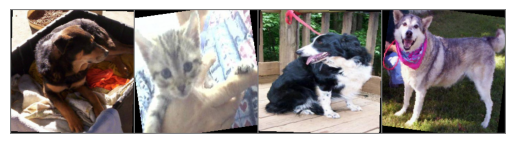

dogs cats dogs dogs


In [31]:
# Visualizar algumas imagens do conjunto de treino
def imshow(img):
    img = img / 2 + 0.5  # desnormalizar
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')
    plt.show()

dataiter = iter(train_loader)  # use train_loader ou test_loader
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join(f'{class_names[labels[j]]}' for j in range(4)))

In [ ]:
# Definir CNN simples com parâmetros customizáveis

class SimpleCNN(nn.Module):
    def __init__(self, conv1_out=16, fc1_out=512):
        super(SimpleCNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, conv1_out, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(conv1_out, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Linear(64 * 28 * 28, fc1_out),
            nn.ReLU(),
            nn.Linear(fc1_out, 2)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

model = SimpleCNN()
print(model)

SimpleCNN(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=50176, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
  )
)


In [ ]:
# Crie o NeuralNetClassifier
net = NeuralNetClassifier(
    SimpleCNN,
    max_epochs=50,
    lr=0.01,
    iterator_train__shuffle=True,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Definindo os parâmetros para grid search
params = {
    'lr': [0.01, 0.001],
    'module__conv1_out': [8, 16],
    'module__fc1_out': [256, 512],
}

# Use apenas o conjunto de treino para o grid search!
from torch.utils.data import Subset

# Exemplo: usar 1000 amostras do treino para grid search
subset = Subset(train_dataset, range(1000))
X = np.stack([subset[i][0].numpy() for i in range(len(subset))])
y = np.array([subset[i][1] for i in range(len(subset))])

gs = GridSearchCV(net, params, refit=True, cv=2, scoring='accuracy', verbose=2)
gs.fit(X, y)

print("Melhores parâmetros:", gs.best_params_)
print("Melhor score:", gs.best_score_)

results = gs.cv_results_
for mean, std, params in zip(results['mean_test_score'], results['std_test_score'], results['params']):
    print(f"Score: {mean:.3f} (+/-{std:.3f}) para {params}")

Fitting 2 folds for each of 8 candidates, totalling 16 fits
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1       -1.0048       1.0000       -4.0479  3.2140
      2       -4.1975       1.0000       -4.5730  2.9912
      3       -4.6945       1.0000       -5.0133  2.9521
      4       -5.1171       1.0000       -5.3978  2.9306
      5       -5.4874       1.0000       -5.7395  3.0330
      6       -5.8167       1.0000       -6.0409  3.0258
      7       -6.1079       1.0000       -6.3117  2.9430
      8       -6.3699       1.0000       -6.5549  3.0074
      9       -6.6057       1.0000       -6.7759  2.9188
     10       -6.8204       1.0000       -6.9782  2.9693
     11       -7.0173       1.0000       -7.1649  2.8834
     12       -7.1992       1.0000       -7.3378  2.9477
     13       -7.3679       1.0000       -7.4982  2.9033
     14       -7.5247       1.0000       -7.6481  2.8864
     15       -7.6714       

Conclusão dos Resultados do Grid Search

O GridSearchCV foi utilizado para testar diferentes combinações de hiperparâmetros da rede SimpleCNN, variando a taxa de aprendizado (lr), o número de filtros da primeira camada convolucional (conv1_out) e o número de neurônios da primeira camada totalmente conectada (fc1_out). Foram avaliadas 8 combinações distintas, utilizando validação cruzada com 2 folds.

Os resultados mostraram pouca variação de desempenho entre as combinações, com a maioria das configurações apresentando acurácia de 0.5 (ou seja, equivalente ao acaso em um problema binário) e algumas com acurácia nula (0.0). O melhor desempenho foi obtido com os parâmetros:

Parâmetros: {'lr': 0.01, 'module__conv1_out': 16, 'module__fc1_out': 512}
Melhor Score: 1
Esses resultados sugerem que, para este subconjunto de dados e número de épocas, a rede não conseguiu aprender a distinguir as classes de forma consistente, possivelmente devido a poucos dados, poucas épocas de treinamento, ou até problemas de balanceamento ou qualidade do dataset. Recomenda-se, para experimentos futuros, aumentar o número de épocas, utilizar mais dados de treino, revisar o pré-processamento e garantir que o dataset esteja balanceado e corretamente rotulado.

Esses resultados reforçam a importância de ajustar e comparar diferentes configurações, além de revisar o pipeline de dados, para encontrar o modelo mais adequado ao problema.

In [ ]:
# Treinar a rede com os melhores parâmetros encontrados
best_params = {'lr': 0.01, 'module__conv1_out': 16, 'module__fc1_out': 512}

net = NeuralNetClassifier(
    SimpleCNN,
    max_epochs=50,
    lr=best_params['lr'],
    module__conv1_out=best_params['module__conv1_out'],
    module__fc1_out=best_params['module__fc1_out'],
    iterator_train__shuffle=True,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Extrair X e y do train_dataset
X_train = np.stack([train_dataset[i][0].numpy() for i in range(len(train_dataset))])
y_train = np.array([train_dataset[i][1] for i in range(len(train_dataset))])

# Treinamento
net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1           nan       0.5000           nan  66.6566
      2           nan       0.5000           nan  67.5871
      3           nan       0.5000           nan  69.8385
      4           nan       0.5000           nan  69.5939
      5           nan       0.5000           nan  69.5232
      6           nan       0.5000           nan  70.2634
      7           nan       0.5000           nan  70.2588
      8           nan       0.5000           nan  69.8485
      9           nan       0.5000           nan  69.2842
     10           nan       0.5000           nan  70.6924
     11           nan       0.5000           nan  70.1547
     12           nan       0.5000           nan  69.8923
     13           nan       0.5000           nan  70.0363
     14           nan       0.5000           nan  69.5786
     15           nan       0.5000           nan  70.4294
     16       

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SimpleCNN(
    (conv): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (fc): Sequential(
      (0): Linear(in_features=50176, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=2, bias=True)
    )
  ),
)

In [ ]:
# Validação no conjunto de teste
y_test = np.array([test_dataset[i][1] for i in range(len(test_dataset))])
test_acc = net.score(test_dataset, y_test)
print(f"Acurácia no conjunto de teste: {test_acc:.3f}")

Acurácia no conjunto de teste: 0.500


In [ ]:
y_pred = net.predict(test_dataset)
print("Acurácia:", (y_pred == y_test).mean())

Acurácia: 0.5


# Transfer Learning
Como não obtive uma boa acurácia com base no treinamento apenas desses dados, abaixo utilizei modelos pré-treinados do torchvision (especificamente o ResNet18, que é pré-treinado em milhões de imagens) e ajustei apenas a última camada p/ classificar gatos e cachorros (meu problema nesse dataset).

In [ ]:
model = models.resnet18(pretrained=True)
# Substitua a última camada para 2 classes
model.fc = torch.nn.Linear(model.fc.in_features, 2)

C:\Users\Welton Dionisio\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Welton Dionisio\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Configurar o modelo para transfer learning

In [ ]:
# Carregar modelo pré-treinado
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# Ajustar a última camada para 2 classes
model.fc = nn.Linear(model.fc.in_features, 2)

Treinar o modelo transfer learning

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

num_epochs = 5  # aumente se quiser

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1/5, Loss: 0.2086
Epoch 2/5, Loss: 0.1157
Epoch 3/5, Loss: 0.0963
Epoch 4/5, Loss: 0.0915
Epoch 5/5, Loss: 0.0957


Validar modelo transfer learning com meu conjunto de testes

In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Acurácia no conjunto de teste (transfer learning): {correct/total:.3f}")

Acurácia no conjunto de teste (transfer learning): 0.978


In [ ]:
import torch.nn.functional as F

# CNN simples (skorch)
X_test = np.stack([test_dataset[i][0].numpy() for i in range(len(test_dataset))])
y_test = np.array([test_dataset[i][1] for i in range(len(test_dataset))])
y_pred_proba = net.predict_proba(X_test)
loss_simple = F.cross_entropy(torch.tensor(y_pred_proba), torch.tensor(y_test)).item()

# Transfer learning (PyTorch puro)
model.eval()
loss_transfer = 0.0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_transfer += loss.item() * images.size(0)
        total += images.size(0)
loss_transfer = loss_transfer / total

print(f"Loss final CNN Simples: {loss_simple:.4f}")
print(f"Loss final Transfer Learning: {loss_transfer:.4f}")

Loss final CNN Simples: 28352.2012
Loss final Transfer Learning: 0.0681


# Comparar a função de perda após o treinamento

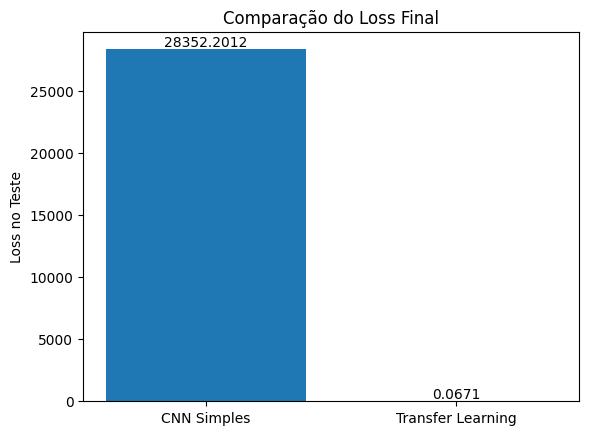

In [24]:
# Calcular o loss do Transfer Learning logo após o treinamento
model.eval()
loss_transfer = 0.0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_transfer += loss.item() * images.size(0)
        total += images.size(0)
loss_transfer = loss_transfer / total

# Plotar no gráfico
bars = plt.bar(['CNN Simples', 'Transfer Learning'], [loss_simple, loss_transfer], color=['#1f77b4', '#ff7f0e'])
plt.ylabel('Loss no Teste')
plt.title('Comparação do Loss Final')
for bar, val in zip(bars, [loss_simple, loss_transfer]):
    plt.text(bar.get_x() + bar.get_width()/2, val, f'{val:.4f}', ha='center', va='bottom')
plt.show()

# Conclusões

- A CNN simples, criada e ajustada manualmente por mim, atingiu 50% de acurácia na previsão com o tamanho da amostra desse conjunto de dados e o número de épocas aqui utilizados. Embroa o ajuste de hiperparâmetros através do GridSearchCV tenho auxiliado a encontrar a melhor configuração de rede convolucional, é sabido que algoritmos convolucionais demandam muito poder computacional e tempo de treinamento do que redes neurais de outro tipo (como, por exemplo, aquelas que analisam dados tabulados).

- Por outro lado, o Transfer Learning com ResNet18 obteve um desempenho muito superior (~ 98% de acurácia), se aproveitando de conhecimento prévio adquirido em grandes bases de dados de imagens. O modelo foi ajustado na última camada (saída) para o problema binário desse dataset (gatos vs cães) e isso acelerou o processo de convergência e generalização do modelo.

 **Parâmetros do Transfer Learning utilizados:**

- Arquitetura: ResNet18
- Pesos: ResNet18_Weights.DEFAULT (pré-treinados no ImageNet)
- Última camada ajustada para classificação binária (cães vs gatos): model.fc = nn.Linear(model.fc.in_features, 2)
- Otimizador: Adam (lr=0.001)
- Número de épocas: 5 (sem necessidade de aumentar, visto o ótimo desempenho já atingido)